In [1]:
import gammapy
print(gammapy.__version__)

0.14.dev287+g3fd5e2676


# **Test the new (Adaptive)RingBackroundMaker**

In [2]:
from gammapy.cube.fit import MapDataset, MapDatasetOnOff
from gammapy.cube.ring import RingBackgroundMaker, AdaptiveRingBackgroundMaker
from gammapy.maps import WcsNDMap, WcsGeom, MapAxis, Map
from gammapy.data import DataStore
from gammapy.cube.make import MapDatasetMaker

In [3]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

Produce a mapdataset:

In [5]:
data_store = DataStore.from_file(
    "/home/luca/GAMMAPY_DATA/hess-dl3-dr1/hess-dl3-dr3-with-background.fits.gz"
)
mask = data_store.obs_table["TARGET_NAME"] == "Crab"
obs_table = data_store.obs_table[mask]
observations = data_store.get_observations(obs_table["OBS_ID"])

energy_axis = MapAxis.from_edges(
    np.logspace(0, 1.0, 5), unit="TeV", name="ENERGY", interp="log"
)
geom = WcsGeom.create(
    skydir=SkyCoord(83.633, 22.014, unit="deg"),
    binsz=0.02,
    width=(10, 10),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

In [6]:
regions = CircleSkyRegion(center=SkyCoord(83.633, 22.014, unit="deg"), radius=0.15 * u.deg)

# Ring (non adaptive)

In [15]:
%%timeit
ring_bkg_maker = RingBackgroundMaker(r_in="0.2 deg", width="0.3 deg")
map_dataset_maker = MapDatasetMaker(geom=geom, offset_max="2 deg")

geom_squashed = geom.to_image().to_cube([energy_axis.squash()])
stacked = MapDatasetOnOff.create(geom_squashed)

for obs in observations:
    dataset = map_dataset_maker.run(obs)
    dataset = dataset.to_image()
    
    geom_cutout = dataset.counts.geom
    exclusion = Map.from_geom(geom_cutout)
    exclusion.data = exclusion.geom.region_mask([regions], inside=False)
    
    dataset_on_off = ring_bkg_maker.run(dataset, exclusion)
    stacked.stack(dataset_on_off)

2.61 s ± 125 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


(<Figure size 1800x288 with 8 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f95baeb3a20>)

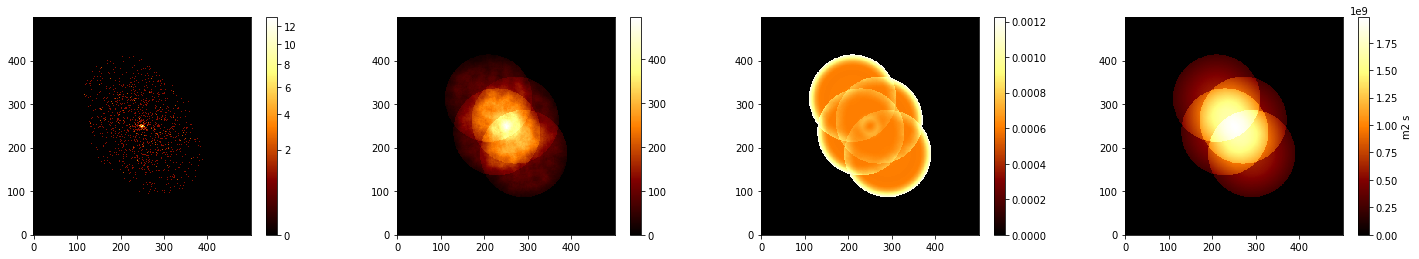

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 4))
stacked.counts.sum_over_axes().plot(add_cbar=True, stretch="sqrt", ax=axes[0])
stacked.counts_off.sum_over_axes().plot(add_cbar=True, ax=axes[1])
stacked.alpha.sum_over_axes().plot(add_cbar=True, ax=axes[2])
stacked.exposure.sum_over_axes().plot(add_cbar=True, ax=axes[3])

In [11]:
stacked.alpha.sum_over_axes().data[200][200]

0.000740094222806022

# Adaptive Ring

In [16]:
%%timeit
ring_bkg_maker = AdaptiveRingBackgroundMaker(r_in="0.2 deg", r_out_max="2 deg", width="0.3 deg", stepsize="0.2 deg")
map_dataset_maker = MapDatasetMaker(geom=geom, offset_max="2 deg")

geom_squashed = geom.to_image().to_cube([energy_axis.squash()])
stacked = MapDatasetOnOff.create(geom_squashed)

for obs in observations:
    dataset = map_dataset_maker.run(obs)
    dataset = dataset.to_image()
    
    geom_cutout = dataset.counts.geom
    exclusion = Map.from_geom(geom_cutout)
    exclusion.data = exclusion.geom.region_mask([regions], inside=False)
    
    dataset_on_off = ring_bkg_maker.run(dataset, exclusion)
    dataset_on_off.mask_safe = Map.from_geom(geom_cutout, data=np.ones(dataset_on_off.data_shape, dtype=bool))
    stacked.stack(dataset_on_off)

3.08 s ± 334 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


(<Figure size 1800x288 with 8 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f95bf238a58>)

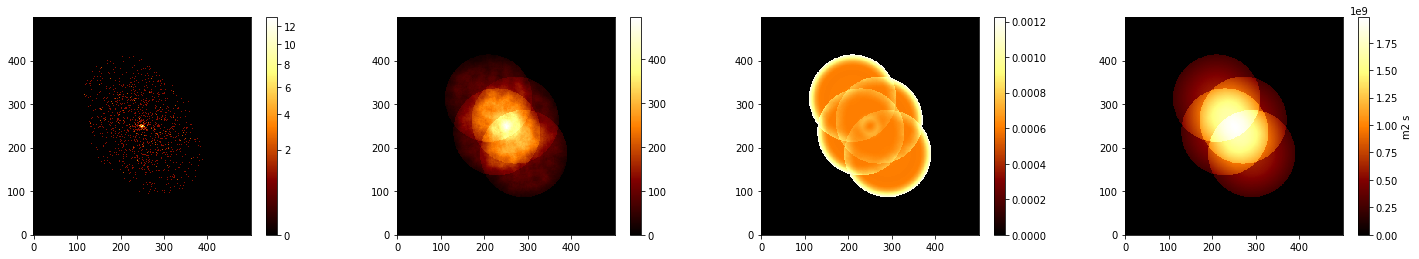

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 4))
stacked.counts.sum_over_axes().plot(add_cbar=True, stretch="sqrt", ax=axes[0])
stacked.counts_off.sum_over_axes().plot(add_cbar=True, ax=axes[1])
stacked.alpha.sum_over_axes().plot(add_cbar=True, ax=axes[2])
stacked.exposure.sum_over_axes().plot(add_cbar=True, ax=axes[3])

In [14]:
stacked.alpha.sum_over_axes().data[200][200]

0.0007400942321775283